In [116]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
#%matplotlib notebook
sns.set(color_codes=True)
sns.set(style="white")
#sns.set(font="monospace")
from fastcluster import linkage


from scipy.cluster.hierarchy import dendrogram, set_link_color_palette
from fastcluster import linkage
from matplotlib.colors import rgb2hex, colorConverter

pd.options.display.width = 1000
pd.options.display.max_colwidth = 150
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:76% !important; }</style>"))

from pairwise import *
from preprocess import *
from dimensionality_reduction import *
from ebi_summarize_data import check_df
from toolbox import mapp, restore_keywords_from_metadata, vectorize_df
from metadata_keywords import binarize_keyword_metadata
from metadata_taxonomy import collapse_by_taxonomic_level
from plots import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['histogram', 'log']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
md = pd.read_csv('/D/ebi/DEFAULT_METADATA.tsv', sep="\t", index_col=False)
tax_md = pd.read_csv('/D/ebi/taxonomy_metadata.tsv', sep="\t", index_col=False)

/usr/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [32]:
Ai = pd.read_csv('/D/ebi/A_OTU-TSV_v2_intestine.tsv', sep="\t", index_col=0)

In [5]:
A_fulli = pd.read_csv('/D/ebi/A_OTU-TSV_v2.tsv', sep="\t", index_col = 0)

# Make it a higher-level taxonomic unit matrix

In [33]:
Ai = delete_empty(collapse_by_taxonomic_level(Ai, tax_md, by='family'))

In [35]:
A_log = log_transform_counts(Ai)

In [34]:
A_corana = correspondence_analysis_transform(Ai)

May be implemented incorrectly


In [21]:
#A_full = log_transform_counts(A_fulli)
#A_full = correspondence_analysis_transform(A_fulli)

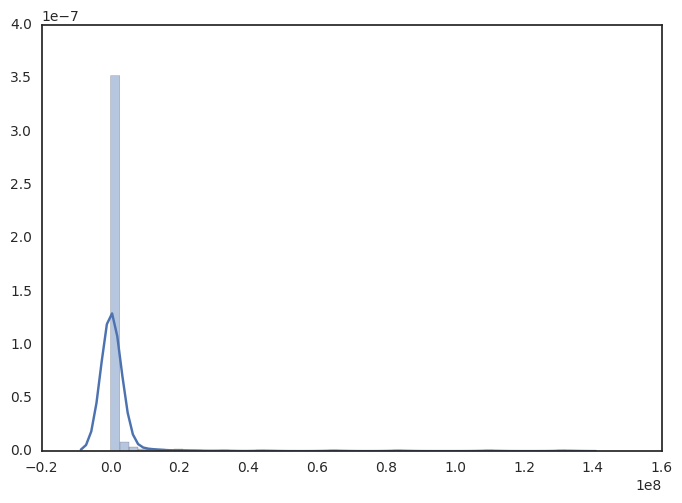

In [36]:
sns.distplot(Ai.sum());

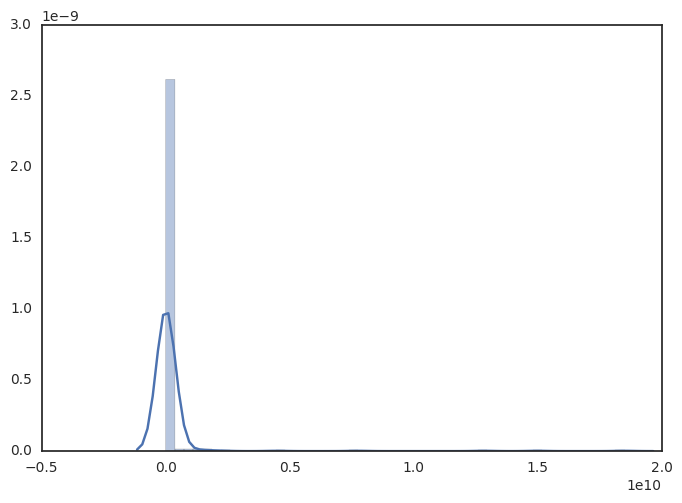

In [37]:
sns.distplot(A_corana.sum());

In [48]:
# looks pretty but there are lots of nans that are not plotted
pd.isnull(A_log).sum().sum()

6473248

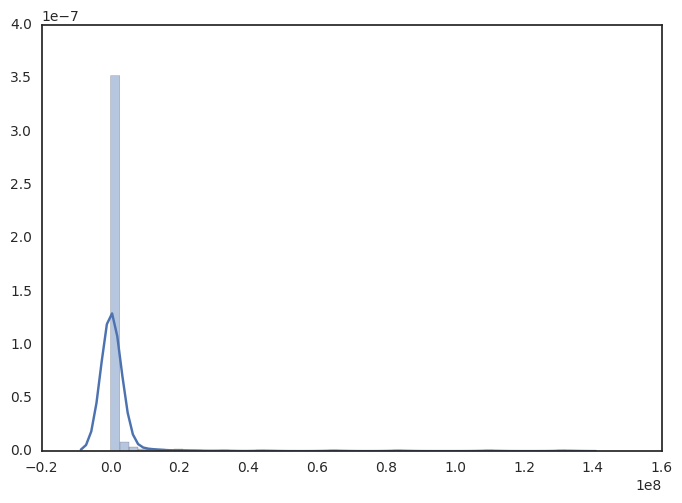

In [54]:
A_log_alt = Ai
A_log_alt[A_log_alt == 0] = 0.0000000001
log_transform_counts(A_log_alt)
sns.distplot(A_log_alt.sum());

In [130]:
# decide which to use
A = Ai

In [132]:
# reduce further (so far no pairwise metric takes into account anything but the two vectors in question, I think,
# so I can reduce right here)
print(A.shape)
A = A.ix[:, A.sum(0) > 10000]
selected_taxs = A.columns
print(A.shape)

(15013, 145)
(15013, 145)


# Distances between taxons

In [133]:
tax_dist = pd.DataFrame(pairwise_distances(A.T, metric='braycurtis'), columns = A.columns, index = A.columns)

In [134]:
tax_dist_long = pairwise_to_long(tax_dist, colnames = ["taxon1", "taxon2", "Bray-Curtis distance"])#, delete_self_self=True)

In [146]:
tax_dist_long.describe()

Bray-Curtis distance
count          21025.000000
mean               0.946647
std                0.112358
min                0.000000
25%                0.948936
50%                0.983471
75%                0.995056
max                0.999986

In [135]:
tax_dist_long.sort_values("Bray-Curtis distance", ascending=False).drop_duplicates().head()

taxon1              taxon2  Bray-Curtis distance
6522   Enterobacteriaceae           auto67_4W              0.999986
20634           auto67_4W  Enterobacteriaceae              0.999986
1882       Bacteroidaceae           auto67_4W              0.999984
20602           auto67_4W      Bacteroidaceae              0.999984
15947     Ruminococcaceae           auto67_4W              0.999979

# Correlations between taxons

In [136]:
tax_corr = A.corr() # of columns

In [173]:
tax_corr_long = pairwise_to_long(tax_corr, colnames = ["taxon1", "taxon2", "Pearson's correlation"])#, delete_self_self=True)

In [138]:
tax_corr_long.sort_values("Pearson's correlation", ascending=False).drop_duplicates().head()

taxon1               taxon2  Pearson's correlation
0        Acetobacteraceae     Acetobacteraceae                    1.0
6716  Erysipelotrichaceae  Erysipelotrichaceae                    1.0
7592     Fusobacteriaceae     Fusobacteriaceae                    1.0
7446    Flavobacteriaceae    Flavobacteriaceae                    1.0
7300     Fibrobacteraceae     Fibrobacteraceae                    1.0

Apart from taxon X - taxon X interactions, correlation of 1 may also represent (and probably does) just very little information to be has in the first place (i.e. all zeros). Not a well suited metric for count data!

# Mutual information; taxons. Binarize the data?

In [205]:
#dużo czasu
#tax_mi = mutual_information(A)

In [206]:
tax_mi = pd.read_csv('/P/metag/data/MI_intestine_tax_family.tsv', sep='\t', index_col=0)
#tax_mi_bin= pd.read_csv('/P/metag/data/MI_Fecal_tax_bin.csv', sep='\t', index_col=0)
tax_mi = tax_mi.ix[selected_taxs, selected_taxs]
tax_mi.shape

(145, 145)

In [217]:
tax_mi_long = pairwise_to_long(tax_mi, colnames = ["taxon1", "taxon2", "mutual information"])

In [218]:
tax_mi_long.sort_values("mutual information", ascending=False).drop_duplicates().head()

taxon1              taxon2  mutual information
9198      Lachnospiraceae     Lachnospiraceae            7.826834
15914     Ruminococcaceae     Ruminococcaceae            7.698077
1752       Bacteroidaceae      Bacteroidaceae            7.383963
6424   Enterobacteriaceae  Enterobacteriaceae            7.275960
18396     Veillonellaceae     Veillonellaceae            6.626970

# Pairwise plots

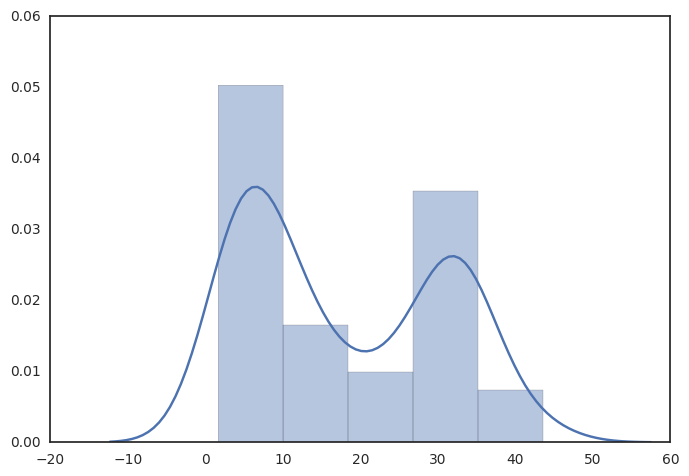

In [139]:
sns.distplot(tax_corr.sum());

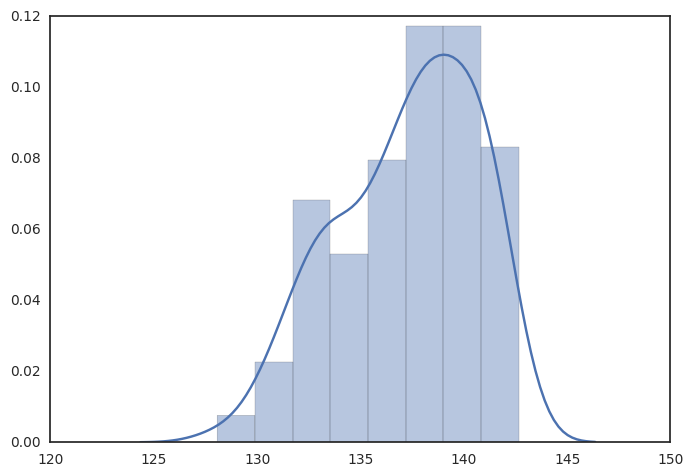

In [140]:
sns.distplot(tax_dist.sum());

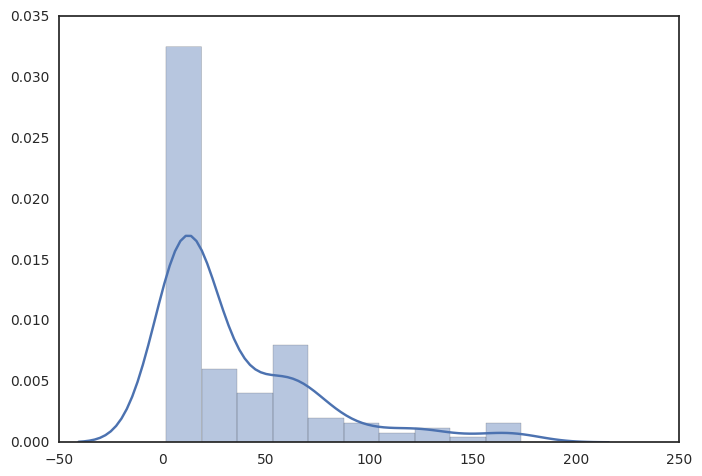

In [209]:
sns.distplot(tax_mi.sum());

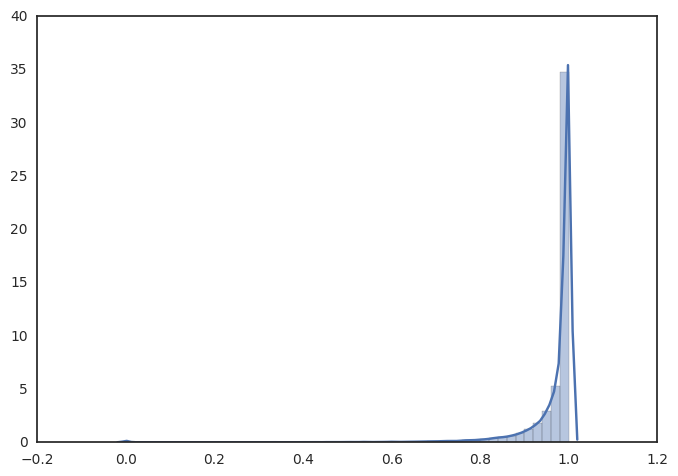

In [117]:
sns.distplot(vectorize_df(tax_dist));

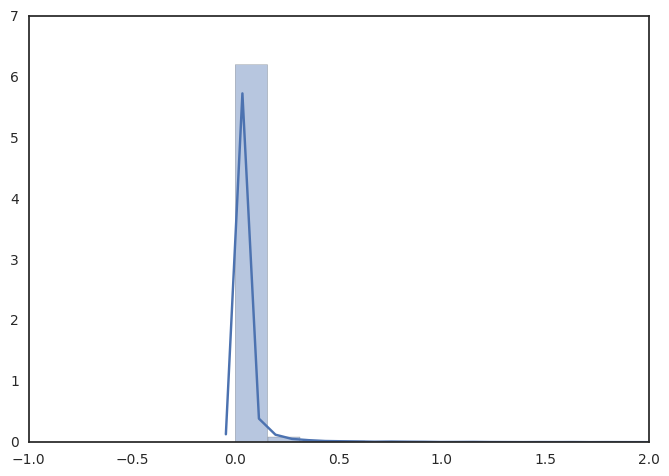

In [187]:
p3 = sns.distplot(vectorize_df(tax_mi))
p3.axes.set_xlim(-1,2);

In [188]:
#p20 = sns.clustermap(tax_dist.applymap(lambda x: 1-x))
#plt.setp(p20.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
#plt.title("Tax 1-dist")
#plt.show()

In [211]:
color_by="phylum"
tax_dist_plot = add_multilevel_col_names(tax_dist, tax_md, new_level=color_by, existing_level="family")
tax_corr_plot = add_multilevel_col_names(tax_corr, tax_md, new_level=color_by, existing_level="family")
tax_mi_plot = add_multilevel_col_names(tax_mi, tax_md, new_level=color_by, existing_level="family")

Changed arg is_biom_mapping to existing_level, so pass the corresponding colname in mapping file!
Changed arg is_biom_mapping to existing_level, so pass the corresponding colname in mapping file!
Changed arg is_biom_mapping to existing_level, so pass the corresponding colname in mapping file!


In [166]:
distance_matrix_plots(tax_dist_plot.applymap(lambda x: 1-x), use_index_level=color_by);

In [168]:
distance_matrix_plots(tax_corr_plot, use_index_level=color_by);

In [220]:
print(tax_mi_plot.max().max(), tax_mi_plot.min().min())
distance_matrix_plots(tax_mi_plot, use_index_level=color_by);

7.8268339278 0.00107382057145


In [86]:
# from sns.clustermap: linkages for dendrogram (so it is consistent with seaborn plots)
# example: output of plots.distance_matrix_plots()
col_link = p20.dendrogram_col.linkage # linkage matrix for columns
row_link = p20.dendrogram_row.linkage # linkage matrix for rows

In [ ]:
# dendrogram

In [47]:
#df = tax_corr.ix[:100, :120]
#df = delete_empty(collapse_by_taxonomic_level(Ai, tax_md, by='family'))
#df = df.corr()
#test_link = linkage(X = df, method='ward')

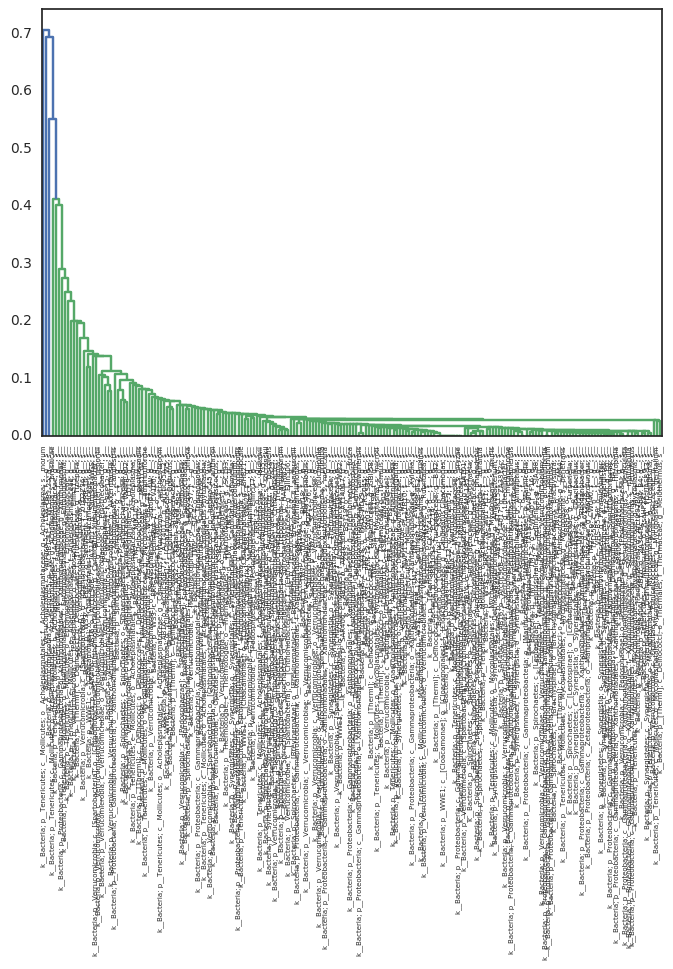

In [104]:
den = dendrogram(row_link, labels=MI_tax_bin.index) # abv_threshold_color='#AAAAAA')
plt.xticks(rotation=90)
plt.figure(figsize=(12,4))
#sns.despine(**no_spine); ??

# Summarize pairwise data

In [ ]:
# make a table with a overlapping, correlation, eicl distance, mi, p-val from glm

In [1]:
overlap = pd.read_csv('/P/metag/data/n_overlapping_intestine.tsv', sep='\t', index_col=0)

In [66]:
#for df in [tax_dist_long.reset_index(), tax_corr_long.reset_index(), tax_mi_long.reset_index()]:
#    print("SHAPE: ", df.shape)
#    print("INDEX: ", df.index)
#    print("COLUMNS: ", df.columns)
#    print(df.head())

In [229]:
summ_pairwise = pd.merge(tax_corr_long, tax_dist_long)
summ_pairwise = pd.merge(summ_pairwise, tax_mi_long)#, on = ['taxon1', 'taxon2']) (intersection is default)
summ_pairwise = summ_pairwise[ summ_pairwise[summ_pairwise.columns[0]] != summ_pairwise[summ_pairwise.columns[1]] ]

In [230]:
summ_pairwise.sort_values("mutual information", ascending=False).drop_duplicates()

taxon1                 taxon2  Pearson's correlation  Bray-Curtis distance  mutual information
9244         Lachnospiraceae        Ruminococcaceae               0.546653              0.400951            6.483877
15868        Ruminococcaceae        Lachnospiraceae               0.546653              0.400951            6.483877
15817        Ruminococcaceae         Bacteroidaceae               0.523811              0.478052            6.190595
1849          Bacteroidaceae        Ruminococcaceae               0.523811              0.478052            6.190595
9147         Lachnospiraceae         Bacteroidaceae               0.435958              0.574648            6.132291
1803          Bacteroidaceae        Lachnospiraceae               0.435958              0.574648            6.132291
9179         Lachnospiraceae     Enterobacteriaceae              -0.018437              0.867960            5.695618
6443      Enterobacteriaceae        Lachnospiraceae              -0.018437              0.867960            5.695618
6489      Enterobacteriaceae        Ruminococcaceae              -0.016767              0.862377            5.682611
15849        Ruminococcaceae     Enterobacteriaceae              -0.016767              0.862377            5.682611
6392      Enterobacteriaceae         Bacteroidaceae               0.003544              0.805964            5.537015
1784          Bacteroidaceae     Enterobacteriaceae               0.003544              0.805964            5.537015
9261         Lachnospiraceae        Veillonellaceae               0.206894              0.772674            5.306138
18333        Veillonellaceae        Lachnospiraceae               0.206894              0.772674            5.306138
18379        Veillonellaceae        Ruminococcaceae               0.209316              0.831494            5.198334
15931        Ruminococcaceae        Veillonellaceae               0.209316              0.831494            5.198334
15832        Ruminococcaceae         Clostridiaceae               0.246305              0.853262            5.061302
4024          Clostridiaceae        Ruminococcaceae               0.246305              0.853262            5.061302
3978          Clostridiaceae        Lachnospiraceae               0.134550              0.798508            5.038050
9162         Lachnospiraceae         Clostridiaceae               0.134550              0.798508            5.038050
13403     Porphyromonadaceae        Lachnospiraceae               0.274182              0.798164            5.000488
9227         Lachnospiraceae     Porphyromonadaceae               0.274182              0.798164            5.000488
18282        Veillonellaceae         Bacteroidaceae               0.175807              0.889866            4.981628
1866          Bacteroidaceae        Veillonellaceae               0.175807              0.889866            4.981628
13449     Porphyromonadaceae        Ruminococcaceae               0.634483              0.843818            4.908115
15897        Ruminococcaceae     Porphyromonadaceae               0.634483              0.843818            4.908115
1832          Bacteroidaceae     Porphyromonadaceae               0.385391              0.859164            4.854757
13352     Porphyromonadaceae         Bacteroidaceae               0.385391              0.859164            4.854757
6733     Erysipelotrichaceae        Lachnospiraceae               0.361440              0.760676            4.798956
9181         Lachnospiraceae    Erysipelotrichaceae               0.361440              0.760676            4.798956
...                      ...                    ...                    ...                   ...                 ...
5525          Dermacoccaceae        Brachyspiraceae              -0.000332              0.999644            0.003061
2213         Brachyspiraceae         Dermacoccaceae              -0.000332              0.999644            0.003061
10258  Methanocorpusculaceae                

In [231]:
summ_pairwise.sort_values("Pearson's correlation", ascending=False).drop_duplicates()

taxon1                  taxon2  Pearson's correlation  Bray-Curtis distance  mutual information
9132          Koribacteraceae               auto67_4W               0.999632              0.192328            0.022918
20652               auto67_4W         Koribacteraceae               0.999632              0.192328            0.022918
14193  Pseudoalteromonadaceae            Vibrionaceae               0.996665              0.066887            0.199593
18657            Vibrionaceae  Pseudoalteromonadaceae               0.996665              0.066887            0.199593
200        Acholeplasmataceae      Gracilibacteraceae               0.995728              0.793679            0.033566
7976       Gracilibacteraceae      Acholeplasmataceae               0.995728              0.793679            0.033566
18773          Victivallaceae         Marinilabiaceae               0.994768              0.715099            0.018729
9989          Marinilabiaceae          Victivallaceae               0.994768              0.715099            0.018729
213        Acholeplasmataceae         Marinilabiaceae               0.994478              0.685582            0.037268
9861          Marinilabiaceae      Acholeplasmataceae               0.994478              0.685582            0.037268
9915          Marinilabiaceae      Gracilibacteraceae               0.992671              0.362322            0.056738
8043       Gracilibacteraceae         Marinilabiaceae               0.992671              0.362322            0.056738
18706          Victivallaceae      Acholeplasmataceae               0.992450              0.407020            0.014567
274        Acholeplasmataceae          Victivallaceae               0.992450              0.407020            0.014567
9863          Marinilabiaceae           Aerococcaceae               0.992106              0.940336            0.041560
503             Aerococcaceae         Marinilabiaceae               0.992106              0.940336            0.041560
19443         [Chromatiaceae]        Beijerinckiaceae               0.991306              0.667247            0.028430
2019         Beijerinckiaceae         [Chromatiaceae]               0.991306              0.667247            0.028430
4335           Comamonadaceae       Xanthobacteraceae               0.991274              0.994179            0.057155
18879       Xanthobacteraceae          Comamonadaceae               0.991274              0.994179            0.057155
15065        Rhodobacteraceae       Xanthobacteraceae               0.989015              0.893946            0.043904
18953       Xanthobacteraceae        Rhodobacteraceae               0.989015              0.893946            0.043904
18760          Victivallaceae      Gracilibacteraceae               0.988752              0.799609            0.044731
8104       Gracilibacteraceae          Victivallaceae               0.988752              0.799609            0.044731
564             Aerococcaceae          Victivallaceae               0.987708              0.828174            0.054273
18708          Victivallaceae           Aerococcaceae               0.987708              0.828174            0.054273
8119       Gracilibacteraceae             p-2534-18B5               0.987014              0.541599            0.036557
20935             p-2534-18B5      Gracilibacteraceae               0.987014              0.541599            0.036557
1435        Aurantimonadaceae       Xanthobacteraceae               0.985526              0.309417            0.035461
18859       Xanthobacteraceae       Aurantimonadaceae               0.985526              0.309417            0.035461
...                       ...                     ...                    ...                   ...                 ...
3993           Clostridiaceae           Neisseriaceae              -0.026226              0.990196            1.091367
11337           Neisseriaceae          Clostridiaceae              -0.026226              0.9901

In [233]:
summ_pairwise.sort_values("Bray-Curtis distance", ascending=True).drop_duplicates()

taxon1                  taxon2  Pearson's correlation  Bray-Curtis distance  mutual information
14193  Pseudoalteromonadaceae            Vibrionaceae               0.996665              0.066887            0.199593
18657            Vibrionaceae  Pseudoalteromonadaceae               0.996665              0.066887            0.199593
20950             p-2534-18B5   Methanocorpusculaceae               0.982141              0.162164            0.014097
10294   Methanocorpusculaceae             p-2534-18B5               0.982141              0.162164            0.014097
20652               auto67_4W         Koribacteraceae               0.999632              0.192328            0.022918
9132          Koribacteraceae               auto67_4W               0.999632              0.192328            0.022918
20890             p-2534-18B5                    BS11               0.949772              0.228332            0.027164
1594                     BS11             p-2534-18B5               0.949772              0.228332            0.027164
10160   Methanocorpusculaceae                    BS11               0.938149              0.256670            0.012687
1520                     BS11   Methanocorpusculaceae               0.938149              0.256670            0.012687
18859       Xanthobacteraceae       Aurantimonadaceae               0.985526              0.309417            0.035461
1435        Aurantimonadaceae       Xanthobacteraceae               0.985526              0.309417            0.035461
10004         Marinilabiaceae             p-2534-18B5               0.973601              0.319278            0.040539
20948             p-2534-18B5         Marinilabiaceae               0.973601              0.319278            0.040539
1551                     BS11                   RFP12               0.977501              0.322913            0.018177
14655                   RFP12                    BS11               0.977501              0.322913            0.018177
8043       Gracilibacteraceae         Marinilabiaceae               0.992671              0.362322            0.056738
9915          Marinilabiaceae      Gracilibacteraceae               0.992671              0.362322            0.056738
12042      Oceanospirillaceae        Alteromonadaceae               0.927131              0.369606            0.110755
1098         Alteromonadaceae      Oceanospirillaceae               0.927131              0.369606            0.110755
9870          Marinilabiaceae                    BS11               0.963756              0.392624            0.032050
1518                     BS11         Marinilabiaceae               0.963756              0.392624            0.032050
20981             p-2534-18B5                   RFP12               0.876855              0.396090            0.024699
14789                   RFP12             p-2534-18B5               0.876855              0.396090            0.024699
15868         Ruminococcaceae         Lachnospiraceae               0.546653              0.400951            6.483877
9244          Lachnospiraceae         Ruminococcaceae               0.546653              0.400951            6.483877
14715                   RFP12   Methanocorpusculaceae               0.880154              0.404302            0.013444
10251   Methanocorpusculaceae                   RFP12               0.880154              0.404302            0.013444
274        Acholeplasmataceae          Victivallaceae               0.992450              0.407020            0.014567
18706          Victivallaceae      Acholeplasmataceae               0.992450              0.407020            0.014567
...                       ...                     ...                    ...                   ...                 ...
20709               auto67_4W        Streptococcaceae              -0.001864              0.999934            0.035199
17397        Streptococcaceae               auto67_4W              -0.001864              0.9999